# Carregamento das bases de treino e teste:

In [13]:
import pandas as pd

train_df = pd.read_csv('sus_train_smote.csv')
test_df = pd.read_csv('sus_test.csv')

X_train = train_df.drop('H_COST', axis=1)
y_train = train_df['H_COST']

X_test = test_df.drop('H_COST', axis=1)
y_test = test_df['H_COST']

# Avaliação de modelos de classificação com GridSearchCV/RandomizedSearchCV e otimização de Thresholds:

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, roc_curve, auc,
    precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

def get_best_threshold(y_test, probs, metric, recall_target=0.9):

    if metric == 'f1':
        prec, rec, thresholds = precision_recall_curve(y_test, probs)
        f1_scores = 2 * (prec * rec) / (prec + rec + 1e-8)
        best_idx = np.argmax(f1_scores)
        return thresholds[best_idx], f1_scores[best_idx]
    elif metric == 'accuracy':
        thresholds = np.linspace(0, 1, 100)
        acc_scores = [accuracy_score(y_test, probs >= t) for t in thresholds]
        best_idx = np.argmax(acc_scores)
        return thresholds[best_idx], acc_scores[best_idx]
    elif metric == 'youden':
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        youden_index = tpr - fpr
        best_idx = np.argmax(youden_index)
        return thresholds[best_idx], youden_index[best_idx]
    elif metric == 'roc_distance':
        fpr, tpr, thresholds = roc_curve(y_test, probs)
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        best_idx = np.argmin(distances)
        return thresholds[best_idx], 1 - distances[best_idx]
    elif metric == 'recall_target':
        prec, rec, thresholds = precision_recall_curve(y_test, probs)
        possible = [(p, r, t) for p, r, t in zip(prec, rec, thresholds) if r >= recall_target]
        if possible:
            p, r, t = max(possible, key=lambda x: x[0])
            return t, (p, r)
        else:
            return None, None

def evaluate_complete_model(model, param_grid, X_train, y_train, X_test, y_test,
                             model_name="Modelo", search="grid", n_iter=30):
    if search == "grid":
        model_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    elif search == "random":
        model_search = RandomizedSearchCV(model, param_grid, n_iter=n_iter, cv=5,
                                          scoring='accuracy', random_state=42)
    else:
        raise ValueError("Parâmetro 'busca' deve ser 'grid' ou 'random'.")

    model_search.fit(X_train, y_train)

    y_train_pred = model_search.predict(X_train)
    y_test_pred = model_search.predict(X_test)
    y_test_proba = model_search.predict_proba(X_test)[:, 1]

    print(f"\n🏆 Melhores parâmetros - {model_name}: {model_search.best_params_}")
    print("✅ Acurácia treino:", accuracy_score(y_train, y_train_pred))
    print("✅ Acurácia teste:", accuracy_score(y_test, y_test_pred))
    print("\n📄 Classification Report (Treino):\n", classification_report(y_train, y_train_pred, zero_division=0))
    print("\n📄 Classification Report (Teste):\n", classification_report(y_test, y_test_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Não Custo Alto", "Custo Alto"])
    disp.plot(cmap='Blues')
    plt.title(f"Matriz de Confusão - {model_name}")
    plt.grid(False)
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("\n")

    print("\n🔍 Otimizando thresholds...")
    metrics = ['f1', 'accuracy', 'youden', 'roc_distance', 'recall_target']
    results = {}

    for metric in metrics:
        thr, value = get_best_threshold(y_test, y_test_proba, metric=metric)
        if thr is not None:
            if metric == 'recall_target':
                print(f"🎯 Limiar com Recall ≥ 90% e maior precisão: {thr:.3f} (Precisão: {value[0]:.3f}, Recall: {value[1]:.3f})")
            else:
                print(f"🎯 Limiar ótimo ({metric}): {thr:.3f} (Score: {value:.4f})")
            results[metric] = thr
        else:
            print(f"⚠️ Nenhum limiar atinge Recall ≥ 90%")
            results[metric] = None

    return model_search, results


# Warnings:

In [15]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

# Modelos:

## Regressão Logística


🏆 Melhores parâmetros - LogReg - Grid: {'C': 1, 'solver': 'liblinear'}
✅ Acurácia treino: 0.7085843373493976
✅ Acurácia teste: 0.5533333333333333

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.79      0.56      0.66       664
           1       0.66      0.85      0.75       664

    accuracy                           0.71      1328
   macro avg       0.73      0.71      0.70      1328
weighted avg       0.73      0.71      0.70      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.98      0.54      0.70       284
           1       0.09      0.81      0.16        16

    accuracy                           0.55       300
   macro avg       0.54      0.68      0.43       300
weighted avg       0.93      0.55      0.67       300



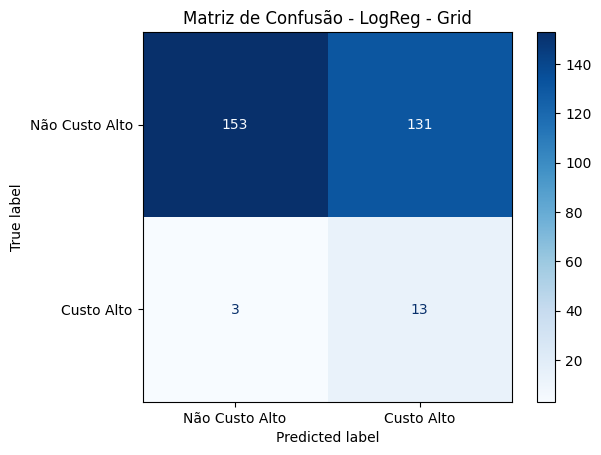

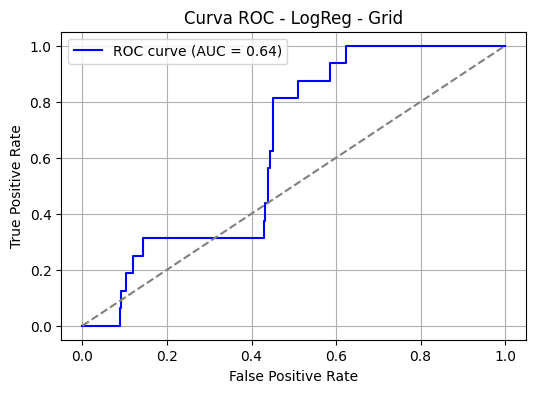




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.511 (Score: 0.1656)
🎯 Limiar ótimo (accuracy): 0.939 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.426 (Score: 0.3768)
🎯 Limiar ótimo (roc_distance): 0.511 (Score: 0.5118)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.426 (Precisão: 0.083, Recall: 1.000)

🏆 Melhores parâmetros - LogReg - Random: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 200, 'C': np.float64(545.5594781168514)}
✅ Acurácia treino: 0.6724397590361446
✅ Acurácia teste: 0.56

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.70      0.61      0.65       664
           1       0.65      0.73      0.69       664

    accuracy                           0.67      1328
   macro avg       0.68      0.67      0.67      1328
weighted avg       0.68      0.67      0.67      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.97      0.55      0.70      

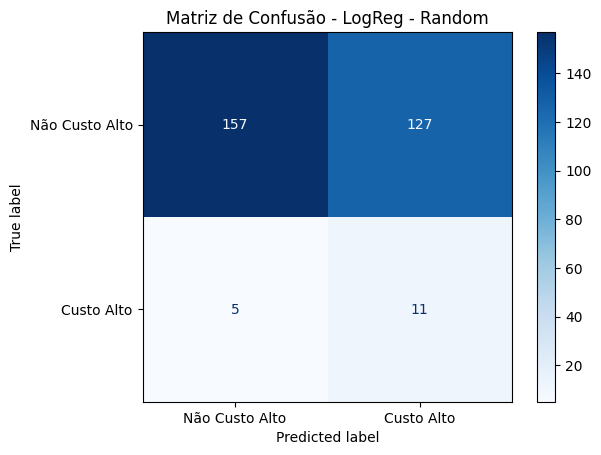

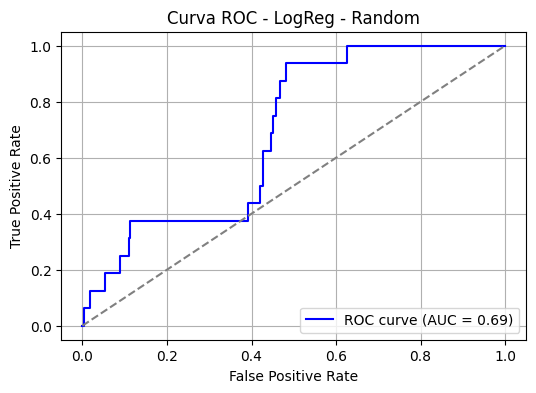




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.678 (Score: 0.2222)
🎯 Limiar ótimo (accuracy): 0.980 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.477 (Score: 0.4551)
🎯 Limiar ótimo (roc_distance): 0.482 (Score: 0.5153)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.477 (Precisão: 0.099, Recall: 0.938)


In [16]:
from sklearn.linear_model import LogisticRegression


param_log = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}


param_log_rand = {
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'max_iter': [100, 200, 300, 500]
}

model_log = LogisticRegression(random_state=42)


grid_model_log, thresholds_grid = evaluate_complete_model(
    model=model_log,
    param_grid=param_log,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LogReg - Grid",
    search="grid"
)


random_model_log, thresholds_random = evaluate_complete_model(
    model=model_log,
    param_grid=param_log_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LogReg - Random",
    search="random",
    n_iter=20
)


## Análise Discriminante Linear (LDA)


🏆 Melhores parâmetros - LDA - Grid: {'shrinkage': 'auto', 'solver': 'lsqr'}
✅ Acurácia treino: 0.6957831325301205
✅ Acurácia teste: 0.5633333333333334

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.76      0.57      0.65       664
           1       0.66      0.82      0.73       664

    accuracy                           0.70      1328
   macro avg       0.71      0.70      0.69      1328
weighted avg       0.71      0.70      0.69      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.99      0.55      0.70       284
           1       0.10      0.88      0.18        16

    accuracy                           0.56       300
   macro avg       0.54      0.71      0.44       300
weighted avg       0.94      0.56      0.67       300



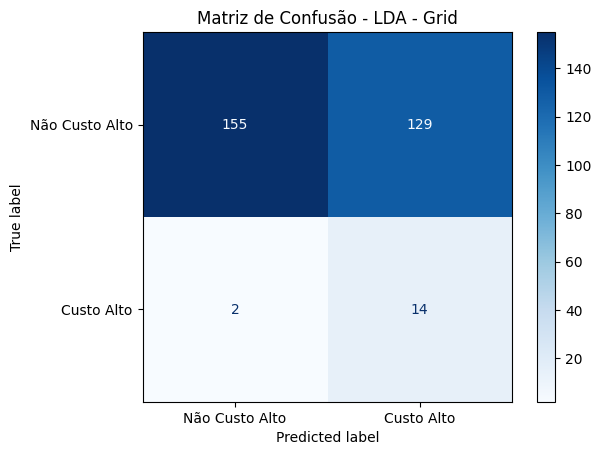

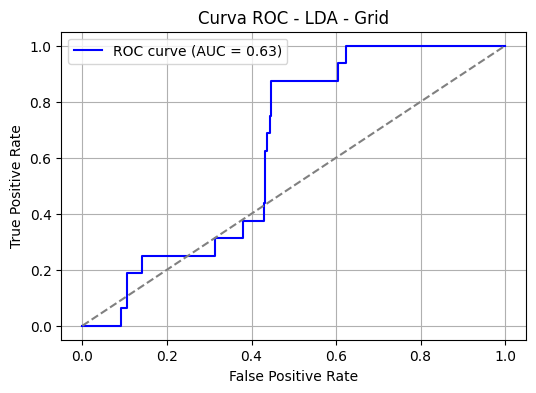




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.510 (Score: 0.1783)
🎯 Limiar ótimo (accuracy): 0.909 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.510 (Score: 0.4278)
🎯 Limiar ótimo (roc_distance): 0.510 (Score: 0.5357)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.409 (Precisão: 0.083, Recall: 1.000)

🏆 Melhores parâmetros - LDA - Random: {'solver': 'lsqr', 'shrinkage': np.float64(0.16)}
✅ Acurácia treino: 0.7085843373493976
✅ Acurácia teste: 0.56

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.79      0.57      0.66       664
           1       0.66      0.85      0.74       664

    accuracy                           0.71      1328
   macro avg       0.73      0.71      0.70      1328
weighted avg       0.73      0.71      0.70      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.98      0.55      0.70       284
           1       0.09      0.81     

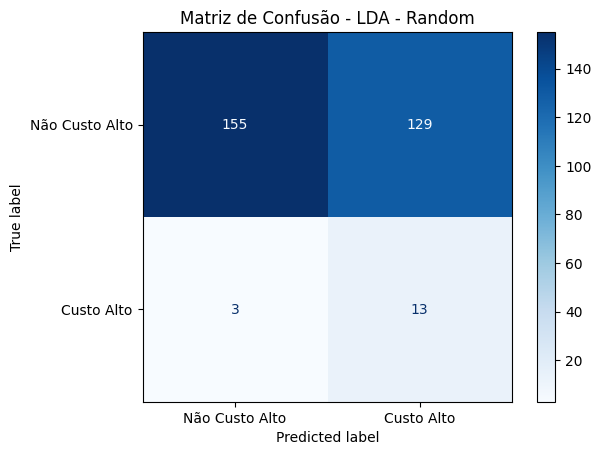

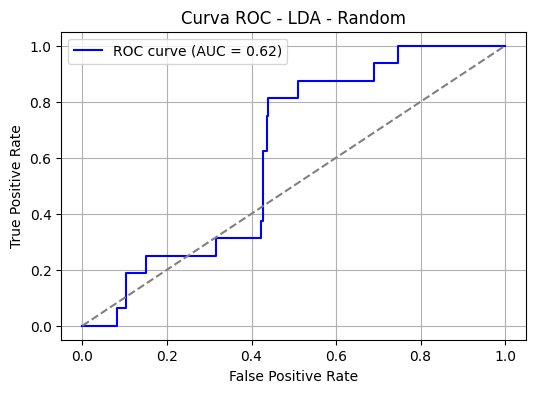




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.515 (Score: 0.1688)
🎯 Limiar ótimo (accuracy): 0.889 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.515 (Score: 0.3724)
🎯 Limiar ótimo (roc_distance): 0.515 (Score: 0.5216)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.425 (Precisão: 0.071, Recall: 0.938)


In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


param_lda = [
    {'solver': ['svd']},  # shrinkage não é compatível com svd
    {'solver': ['lsqr', 'eigen'], 'shrinkage': ['auto', None]}
]


param_lda_rand = [
    {'solver': ['svd']},  # svd não aceita shrinkage
    {
        'solver': ['lsqr'],
        'shrinkage': ['auto', None] + list(np.round(np.linspace(0, 1, 20), 2))
    },
    {
        'solver': ['eigen'],
        'shrinkage': ['auto', None] + list(np.round(np.linspace(0, 1, 20), 2))
    }
]

model_lda = LinearDiscriminantAnalysis()


grid_model_lda, thresholds_grid_lda = evaluate_complete_model(
    model=model_lda,
    param_grid=param_lda,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LDA - Grid",
    search="grid"
)

random_model_lda, thresholds_random_lda = evaluate_complete_model(
    model=model_lda,
    param_grid=param_lda_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LDA - Random",
    search="random",
    n_iter=20
)


## Random Forest Classifier


🏆 Melhores parâmetros - RandomForest - Grid: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
✅ Acurácia treino: 0.9977409638554217
✅ Acurácia teste: 0.92

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       664

    accuracy                           1.00      1328
   macro avg       1.00      1.00      1.00      1328
weighted avg       1.00      1.00      1.00      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       284
           1       0.21      0.19      0.20        16

    accuracy                           0.92       300
   macro avg       0.58      0.57      0.58       300
weighted avg       0.92      0.92      0.92       300



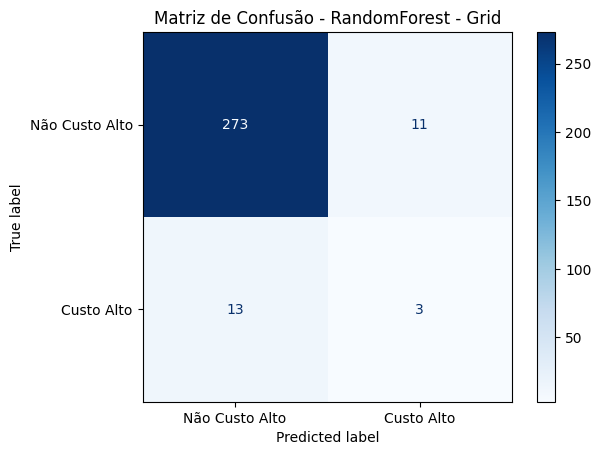

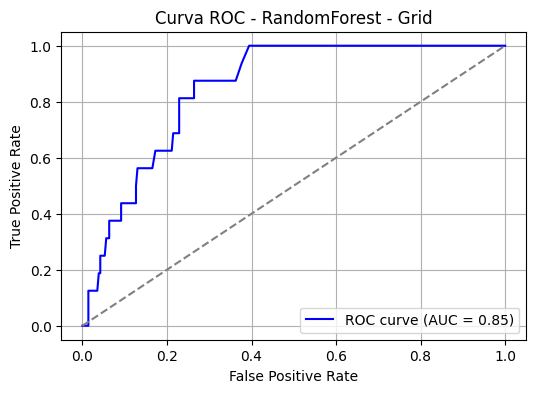




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.360 (Score: 0.3000)
🎯 Limiar ótimo (accuracy): 0.980 (Score: 0.9433)
🎯 Limiar ótimo (youden): 0.085 (Score: 0.6109)
🎯 Limiar ótimo (roc_distance): 0.085 (Score: 0.7078)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.035 (Precisão: 0.125, Recall: 1.000)

🏆 Melhores parâmetros - RandomForest - Random: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'gini', 'bootstrap': False}
✅ Acurácia treino: 0.9841867469879518
✅ Acurácia teste: 0.9166666666666666

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       664
           1       0.99      0.98      0.98       664

    accuracy                           0.98      1328
   macro avg       0.98      0.98      0.98      1328
weighted avg       0.98      0.98      0.98      1328


📄 Classification Report (Teste):
               precision

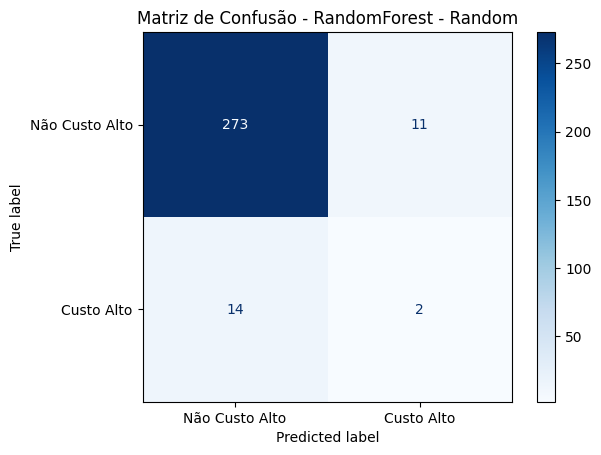

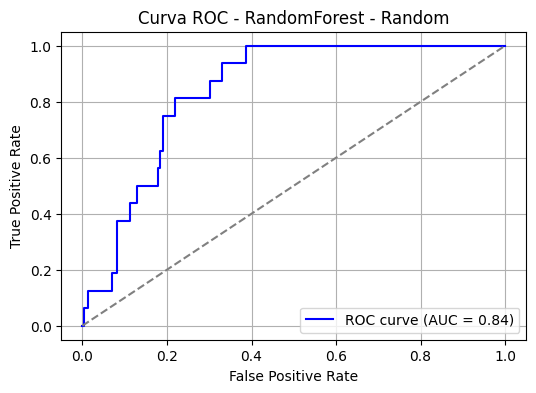




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.179 (Score: 0.2927)
🎯 Limiar ótimo (accuracy): 0.899 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.055 (Score: 0.6127)
🎯 Limiar ótimo (roc_distance): 0.157 (Score: 0.7122)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.089 (Precisão: 0.138, Recall: 0.938)


In [18]:
from sklearn.ensemble import RandomForestClassifier


param_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True]
}


param_rf_rand = {
    'n_estimators': list(range(50, 501, 50)),
    'max_depth': [None] + list(range(5, 31, 5)),
    'min_samples_split': list(range(2, 11)),
    'min_samples_leaf': list(range(1, 11)),
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy', 'log_loss']
}

model_rf = RandomForestClassifier(random_state=42)


grid_model_rf, thresholds_grid_rf = evaluate_complete_model(
    model=model_rf,
    param_grid=param_rf,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="RandomForest - Grid",
    search="grid"
)


random_model_rf, thresholds_random_rf = evaluate_complete_model(
    model=model_rf,
    param_grid=param_rf_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="RandomForest - Random",
    search="random",
    n_iter=50
)


## Gradient Boosting (XGBoost)


🏆 Melhores parâmetros - XGBoost - Grid: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
✅ Acurácia treino: 0.9954819277108434
✅ Acurácia teste: 0.92

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       664

    accuracy                           1.00      1328
   macro avg       1.00      1.00      1.00      1328
weighted avg       1.00      1.00      1.00      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       284
           1       0.21      0.19      0.20        16

    accuracy                           0.92       300
   macro avg       0.58      0.57      0.58       300
weighted avg       0.92      0.92      0.92       300



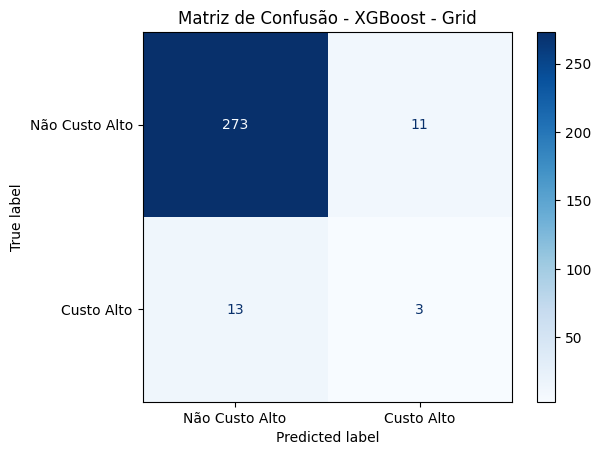

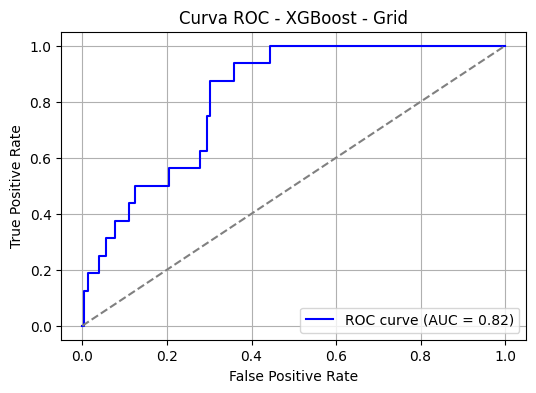




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.150 (Score: 0.2727)
🎯 Limiar ótimo (accuracy): 0.939 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.006 (Score: 0.5783)
🎯 Limiar ótimo (roc_distance): 0.010 (Score: 0.6724)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.006 (Precisão: 0.128, Recall: 0.938)

🏆 Melhores parâmetros - XGBoost - Random: {'subsample': 0.7, 'scale_pos_weight': 1, 'reg_lambda': 0.3, 'reg_alpha': 0.2, 'n_estimators': 1000, 'max_depth': 17, 'learning_rate': 0.08, 'gamma': 0.0, 'colsample_bytree': 0.7, 'booster': 'gbtree'}
✅ Acurácia treino: 0.9947289156626506
✅ Acurácia teste: 0.93

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       664
           1       1.00      0.99      0.99       664

    accuracy                           0.99      1328
   macro avg       0.99      0.99      0.99      1328
weighted avg       0.99      0.99      0.99      1328


📄 Classification Report (T

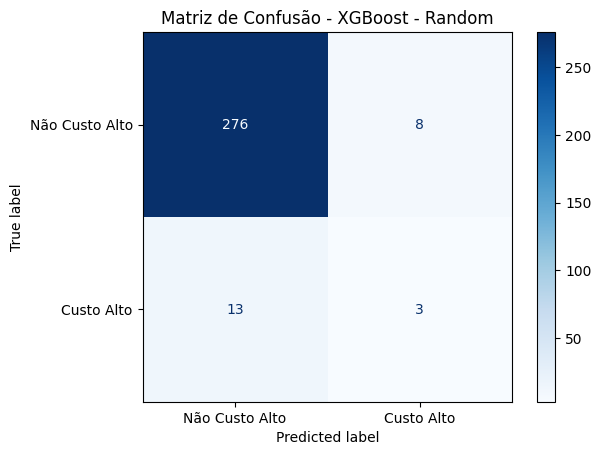

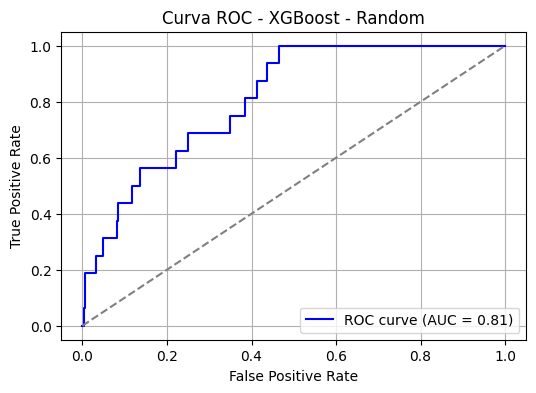




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.126 (Score: 0.2979)
🎯 Limiar ótimo (accuracy): 0.909 (Score: 0.9500)
🎯 Limiar ótimo (youden): 0.002 (Score: 0.5352)
🎯 Limiar ótimo (roc_distance): 0.014 (Score: 0.5998)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.002 (Precisão: 0.108, Recall: 1.000)


In [19]:
from xgboost import XGBClassifier


param_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

param_xgb_rand = {
    'n_estimators': list(range(100, 1001, 100)),
    'max_depth': list(range(3, 21, 1)),
    'learning_rate': np.round(np.linspace(0.01, 0.3, 30), 3).tolist(),
    'subsample': np.round(np.linspace(0.5, 1.0, 11), 2).tolist(),
    'colsample_bytree': np.round(np.linspace(0.5, 1.0, 11), 2).tolist(),
    'gamma': np.round(np.linspace(0, 5, 11), 2).tolist(),
    'reg_alpha': np.round(np.linspace(0, 1, 11), 3).tolist(),
    'reg_lambda': np.round(np.linspace(0, 1, 11), 3).tolist(),
    'scale_pos_weight': [1, 2, 5, 10],
    'booster': ['gbtree', 'gblinear', 'dart']
}

model_xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')


grid_model_xgb, thresholds_grid_xgb = evaluate_complete_model(
    model=model_xgb,
    param_grid=param_xgb,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="XGBoost - Grid",
    search="grid"
)


random_model_xgb, thresholds_random_xgb = evaluate_complete_model(
    model=model_xgb,
    param_grid=param_xgb_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="XGBoost - Random",
    search="random",
    n_iter=50
)


## Gradient Boosting (LightGBM)

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 531, number of negative: 532
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1047
[LightGBM] [Info] Number of data points in the train set: 1063, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499530 -> initscore=-0.001881
[LightGBM] [Info] Start training from score -0.001881
[Li

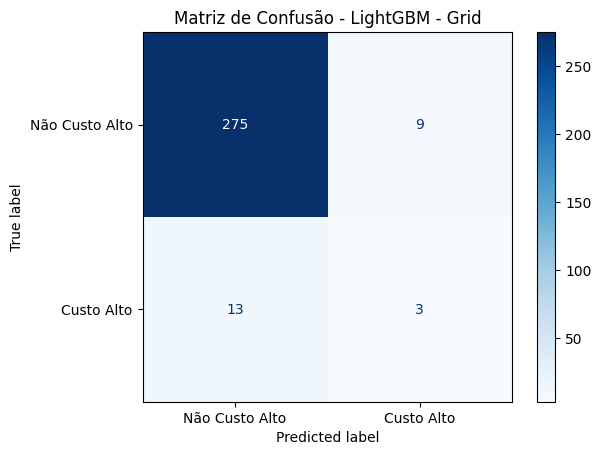

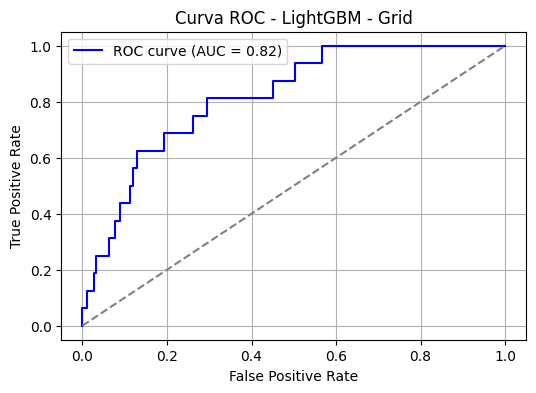

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

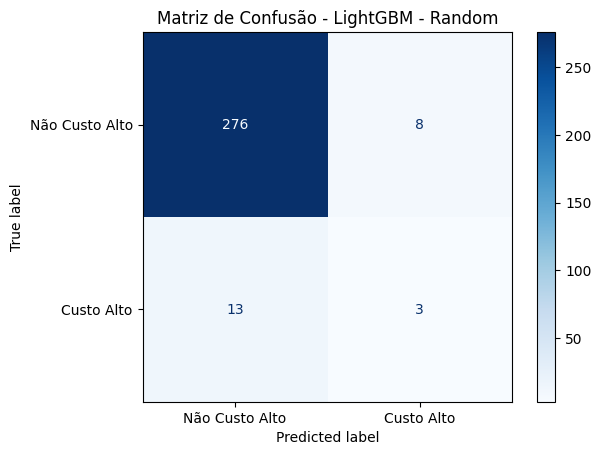

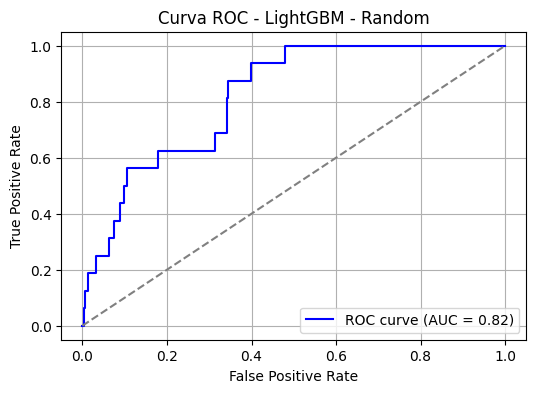




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.124 (Score: 0.3273)
🎯 Limiar ótimo (accuracy): 0.879 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.009 (Score: 0.5396)
🎯 Limiar ótimo (roc_distance): 0.012 (Score: 0.6330)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.009 (Precisão: 0.117, Recall: 0.938)


In [20]:
from lightgbm import LGBMClassifier


param_lgb = {
    'n_estimators': [100, 200],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


param_lgb_rand = {
    'n_estimators': list(range(100, 1001, 100)),
    'max_depth': [-1] + list(range(3, 21)),
    'learning_rate': np.round(np.linspace(0.005, 0.3, 30), 4).tolist(),
    'subsample': np.round(np.linspace(0.5, 1.0, 11), 2).tolist(),
    'colsample_bytree': np.round(np.linspace(0.5, 1.0, 11), 2).tolist(),
    'num_leaves': list(range(15, 150, 5)),
    'min_child_samples': list(range(5, 50, 5)),
    'reg_alpha': np.round(np.linspace(0, 1, 11), 3).tolist(),
    'reg_lambda': np.round(np.linspace(0, 1, 11), 3).tolist(),
    'boosting_type': ['gbdt', 'dart', 'goss']
}

model_lgb = LGBMClassifier(random_state=42)


grid_model_lgb, thresholds_grid_lgb = evaluate_complete_model(
    model=model_lgb,
    param_grid=param_lgb,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LightGBM - Grid",
    search="grid"
)


random_model_lgb, thresholds_random_lgb = evaluate_complete_model(
    model=model_lgb,
    param_grid=param_lgb_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="LightGBM - Random",
    search="random",
    n_iter=50
)


## K-Nearest Neighbors (KNN)


🏆 Melhores parâmetros - KNN - Grid: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
✅ Acurácia treino: 0.9977409638554217
✅ Acurácia teste: 0.86

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       664

    accuracy                           1.00      1328
   macro avg       1.00      1.00      1.00      1328
weighted avg       1.00      1.00      1.00      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.97      0.88      0.92       284
           1       0.17      0.44      0.25        16

    accuracy                           0.86       300
   macro avg       0.57      0.66      0.59       300
weighted avg       0.92      0.86      0.89       300



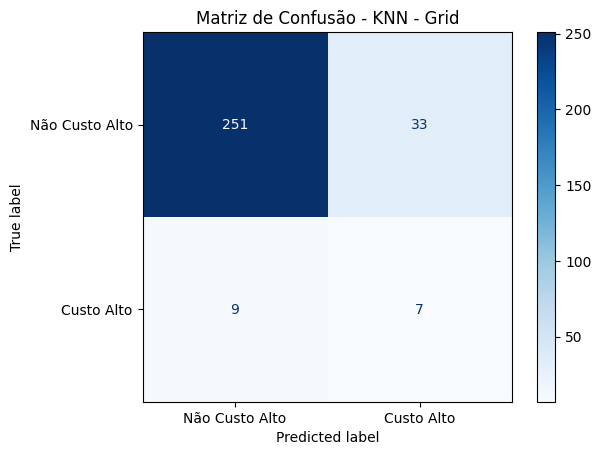

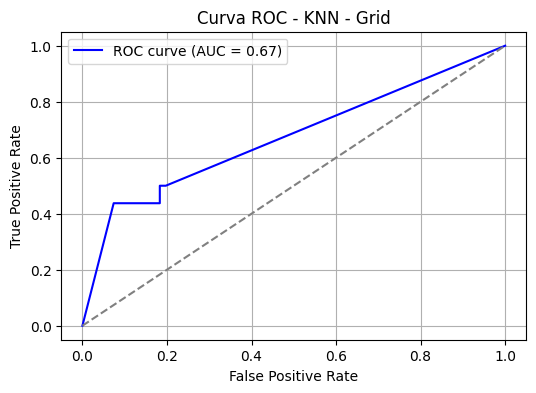




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 1.000 (Score: 0.3182)
🎯 Limiar ótimo (accuracy): 0.899 (Score: 0.9000)
🎯 Limiar ótimo (youden): 1.000 (Score: 0.3636)
🎯 Limiar ótimo (roc_distance): 0.215 (Score: 0.4675)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.000 (Precisão: 0.053, Recall: 1.000)

🏆 Melhores parâmetros - KNN - Random: {'weights': 'uniform', 'p': 2, 'n_neighbors': 1, 'metric': 'manhattan', 'leaf_size': 80, 'algorithm': 'brute'}
✅ Acurácia treino: 0.9977409638554217
✅ Acurácia teste: 0.8733333333333333

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       664
           1       1.00      1.00      1.00       664

    accuracy                           1.00      1328
   macro avg       1.00      1.00      1.00      1328
weighted avg       1.00      1.00      1.00      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0     

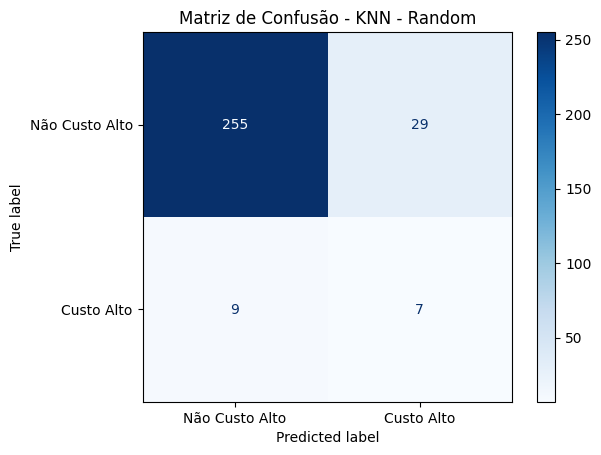

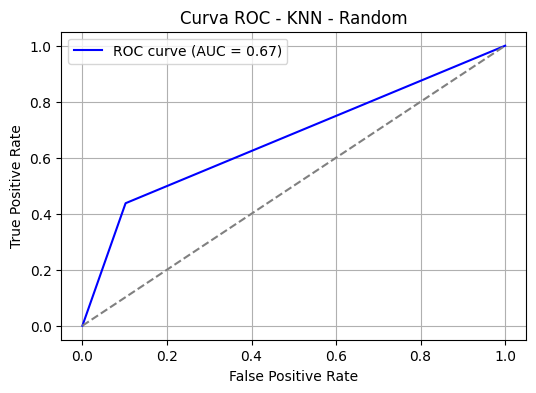




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 1.000 (Score: 0.2692)
🎯 Limiar ótimo (accuracy): 0.010 (Score: 0.8733)
🎯 Limiar ótimo (youden): 1.000 (Score: 0.3354)
🎯 Limiar ótimo (roc_distance): 1.000 (Score: 0.4283)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.000 (Precisão: 0.053, Recall: 1.000)


In [21]:
from sklearn.neighbors import KNeighborsClassifier


param_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


param_knn_rand = {
    'n_neighbors': list(range(1, 51)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': list(range(10, 101, 10)),
    'p': [1, 2],  # 1 = Manhattan, 2 = Euclidean
    'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']
}

model_knn = KNeighborsClassifier()


grid_model_knn, thresholds_grid_knn = evaluate_complete_model(
    model=model_knn,
    param_grid=param_knn,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="KNN - Grid",
    search="grid"
)


random_model_knn, thresholds_random_knn = evaluate_complete_model(
    model=model_knn,
    param_grid=param_knn_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="KNN - Random",
    search="random",
    n_iter=50
)


## Support Vector Machine (SVM)


🏆 Melhores parâmetros - SVM - Grid: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
✅ Acurácia treino: 0.8034638554216867
✅ Acurácia teste: 0.6333333333333333

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.90      0.68      0.78       664
           1       0.74      0.93      0.82       664

    accuracy                           0.80      1328
   macro avg       0.82      0.80      0.80      1328
weighted avg       0.82      0.80      0.80      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.95      0.64      0.77       284
           1       0.06      0.44      0.11        16

    accuracy                           0.63       300
   macro avg       0.51      0.54      0.44       300
weighted avg       0.91      0.63      0.73       300



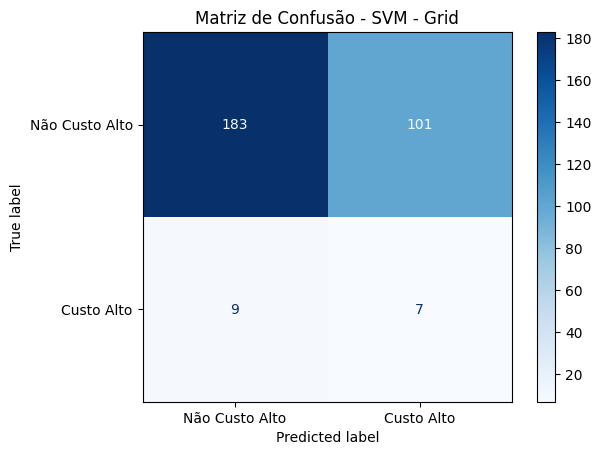

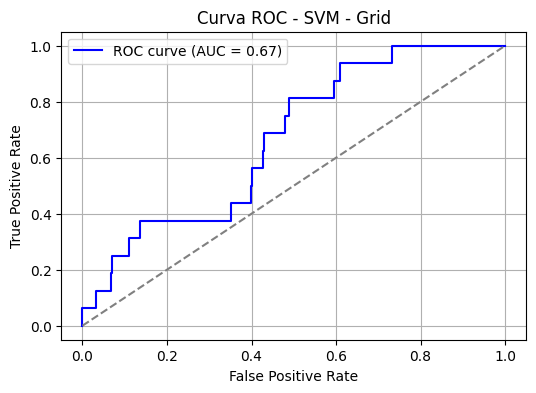




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.730 (Score: 0.2000)
🎯 Limiar ótimo (accuracy): 0.970 (Score: 0.9500)
🎯 Limiar ótimo (youden): 0.070 (Score: 0.3283)
🎯 Limiar ótimo (roc_distance): 0.227 (Score: 0.4759)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.070 (Precisão: 0.080, Recall: 0.938)

🏆 Melhores parâmetros - SVM - Random: {'shrinking': True, 'probability': True, 'kernel': 'poly', 'gamma': 0.7897, 'degree': 3, 'class_weight': None, 'C': np.float64(483.2930238571752)}
✅ Acurácia treino: 0.8516566265060241
✅ Acurácia teste: 0.74

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.93      0.76      0.84       664
           1       0.80      0.94      0.86       664

    accuracy                           0.85      1328
   macro avg       0.86      0.85      0.85      1328
weighted avg       0.86      0.85      0.85      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   supp

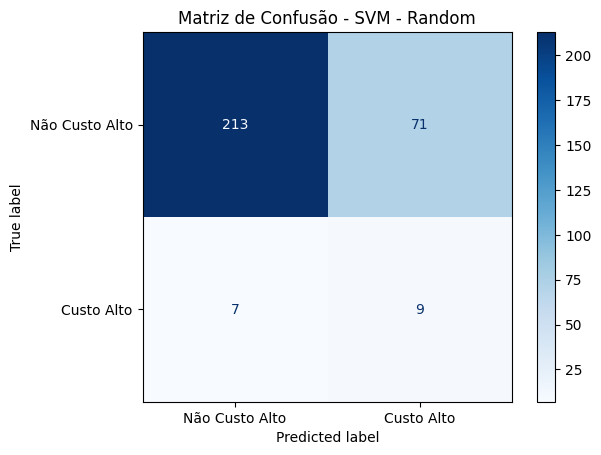

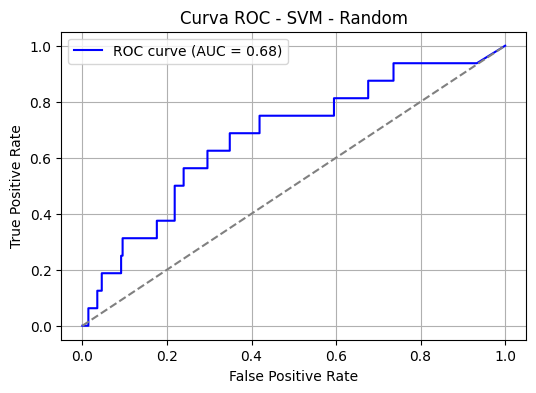




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.696 (Score: 0.2083)
🎯 Limiar ótimo (accuracy): 1.000 (Score: 0.9467)
🎯 Limiar ótimo (youden): 0.353 (Score: 0.3389)
🎯 Limiar ótimo (roc_distance): 0.353 (Score: 0.5318)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.001 (Precisão: 0.067, Recall: 0.938)


In [22]:
from sklearn.svm import SVC

param_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

param_svm_rand = {
    'C': np.logspace(-3, 3, 20),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'] + np.round(np.linspace(0.001, 1, 20), 4).tolist(),
    'degree': list(range(2, 6)),
    'shrinking': [True, False],
    'probability': [True],
    'class_weight': [None, 'balanced']
}

model_svm = SVC(probability=True, random_state=42)

grid_model_svm, thresholds_grid_svm = evaluate_complete_model(
    model=model_svm,
    param_grid=param_svm,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="SVM - Grid",
    search="grid"
)

random_model_svm, thresholds_random_svm = evaluate_complete_model(
    model=model_svm,
    param_grid=param_svm_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="SVM - Random",
    search="random",
    n_iter=50
)


## MLPClassifier (Multi-layer Perceptron)


🏆 Melhores parâmetros - MLP - Grid: {'activation': 'relu', 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'adam'}
✅ Acurácia treino: 0.9262048192771084
✅ Acurácia teste: 0.8866666666666667

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.93      0.92      0.93       664
           1       0.92      0.93      0.93       664

    accuracy                           0.93      1328
   macro avg       0.93      0.93      0.93      1328
weighted avg       0.93      0.93      0.93      1328


📄 Classification Report (Teste):
               precision    recall  f1-score   support

           0       0.97      0.91      0.94       284
           1       0.24      0.50      0.32        16

    accuracy                           0.89       300
   macro avg       0.60      0.70      0.63       300
weighted avg       0.93      0.89      0.91       300



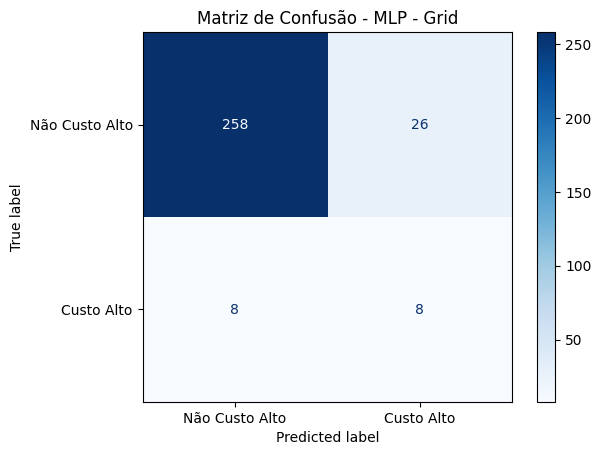

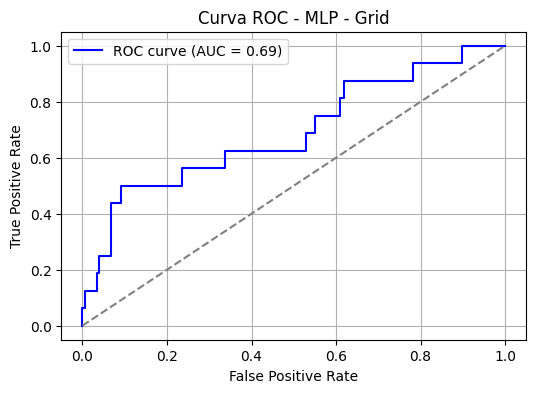




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.671 (Score: 0.3333)
🎯 Limiar ótimo (accuracy): 0.939 (Score: 0.9500)
🎯 Limiar ótimo (youden): 0.507 (Score: 0.4085)
🎯 Limiar ótimo (roc_distance): 0.098 (Score: 0.5029)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.000 (Precisão: 0.063, Recall: 0.938)

🏆 Melhores parâmetros - MLP - Random: {'solver': 'lbfgs', 'momentum': 1.0, 'max_iter': 400, 'learning_rate_init': np.float64(1e-05), 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100, 100), 'early_stopping': True, 'batch_size': 64, 'alpha': np.float64(0.001), 'activation': 'tanh'}
✅ Acurácia treino: 0.9646084337349398
✅ Acurácia teste: 0.8766666666666667

📄 Classification Report (Treino):
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       664
           1       0.95      0.98      0.97       664

    accuracy                           0.96      1328
   macro avg       0.97      0.96      0.96      1328
weighted avg       0.97

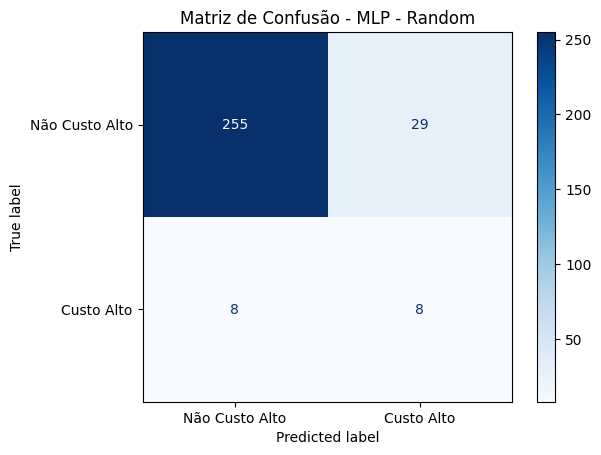

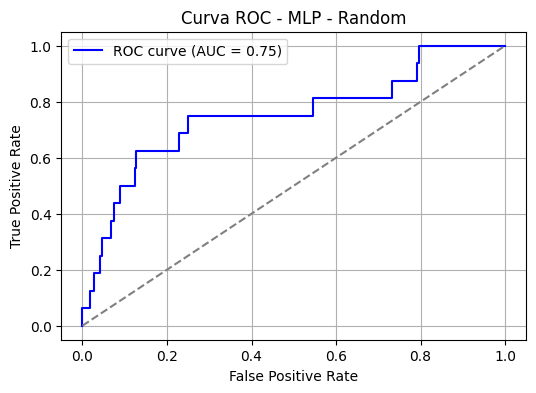




🔍 Otimizando thresholds...
🎯 Limiar ótimo (f1): 0.688 (Score: 0.3265)
🎯 Limiar ótimo (accuracy): 1.000 (Score: 0.9500)
🎯 Limiar ótimo (youden): 0.005 (Score: 0.5000)
🎯 Limiar ótimo (roc_distance): 0.005 (Score: 0.6464)
🎯 Limiar com Recall ≥ 90% e maior precisão: 0.000 (Precisão: 0.066, Recall: 1.000)


In [23]:
from sklearn.neural_network import MLPClassifier

param_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500]
}

param_mlp_rand = {
    'hidden_layer_sizes': [(50,), (100,), (100, 100), (150, 100), (200,)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': np.logspace(-5, 0, 6),
    'alpha': np.logspace(-5, 1, 7),
    'max_iter': list(range(100, 1001, 100)),
    'batch_size': ['auto', 32, 64, 128],
    'momentum': np.round(np.linspace(0.5, 1, 6), 2).tolist(),
    'early_stopping': [True, False]
}

model_mlp = MLPClassifier(random_state=42)

grid_model_mlp, thresholds_grid_mlp = evaluate_complete_model(
    model=model_mlp,
    param_grid=param_mlp,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="MLP - Grid",
    search="grid"
)

random_model_mlp, thresholds_random_mlp = evaluate_complete_model(
    model=model_mlp,
    param_grid=param_mlp_rand,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="MLP - Random",
    search="random",
    n_iter=50
)


# Salvar melhor modelo

### Salvando

In [24]:
import joblib

joblib.dump(grid_model_lgb.best_estimator_, 'best_model_lgb_grid.pkl')

['best_model_lgb_grid.pkl']

### Carregando

In [25]:
load_model = joblib.load('best_model_lgb_grid.pkl')

### Ver nome

In [26]:
print(type(load_model))

<class 'lightgbm.sklearn.LGBMClassifier'>


### Vendo os melhores parâmetros

In [27]:
print("Melhores parâmetros:", grid_model_lgb.best_params_)

Melhores parâmetros: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [28]:
print(load_model.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.8, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 200, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 0.8, 'subsample_for_bin': 200000, 'subsample_freq': 0}


### Fazer previsões e gerar o classification report

In [29]:
y_pred = load_model.predict(X_test)
print("\nClassification Report teste:\n", classification_report(y_test, y_pred, zero_division=0))


Classification Report teste:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       284
           1       0.25      0.19      0.21        16

    accuracy                           0.93       300
   macro avg       0.60      0.58      0.59       300
weighted avg       0.92      0.93      0.92       300

